In [28]:
###api

def SHOW(imagelist,figsize=None,savepath=None):
    num = len(imagelist)
    if figsize==None:
        plt.figure(figsize=(5*num,6))
    else:
        plt.figure(figsize=figsize)
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(imagelist[i],cv2.COLOR_BGR2RGB))
        
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

In [29]:
import os 
import argparse
import numpy as np
import matplotlib.pyplot as plt
import numpy as np  
import cv2  
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)

True
(68, 2)


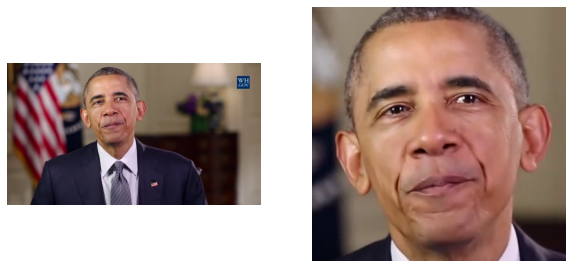

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
path = "/home/chengbin/code/Obama-Lip-Sync/rawData/1.mp4"
cap = cv2.VideoCapture(path)
print(cap.isOpened())

for i in range(30):
    ret, frame = cap.read()

idx = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    idx += 1
    if ret == True:
        input_img = frame
        preds = fa.get_landmarks(input_img)  
        print(preds[0].shape)
        if len(preds[0])==68:
            ## mask
            x, y, w, h = cv2.boundingRect(np.array(preds[0]))
            l = int(max(w,h)*1.5)
            x = int(x-(l-w)/2)
            y = int(y-(l-h)*1.5/2)
            face = input_img.copy()[y:y+l,x:x+l]
            SHOW([input_img,face])
        else:
            print("Error occured ：{}".format(idx))
        
        break
    else:
        break


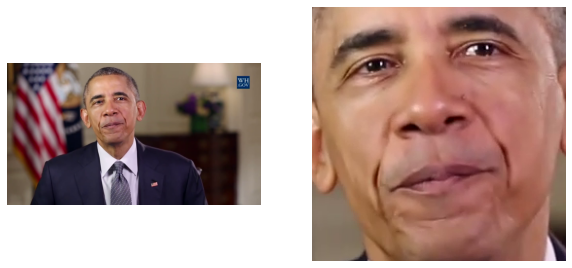

In [136]:
preds = fa.get_landmarks(input_img) 
x, y, w, h = cv2.boundingRect(np.array(preds[0]))
l = int(max(w,h)*1)
x = max(0,int(x-(l-w)/2))
y = max(0,int(y-(l-h)*1.5/2))
face = input_img.copy()[y:y+l,x:x+l]
SHOW([input_img,face])

In [137]:
from src.config import Config
from src.networks import InpaintGenerator
import os
import torch
checkpoint =  "/home/chengbin/code/lafin_school/checkpoints/celeba1024"
config_path = os.path.join(checkpoint,"config.yml")
weight_path = os.path.join(checkpoint,"InpaintingModel_gen.pth")
config = Config(config_path)
model = InpaintGenerator()
data = torch.load(weight_path)
model.load_state_dict(data["generator"])
model.eval()
landmark_img = np.zeros(input_img.shape,input_img.dtype)


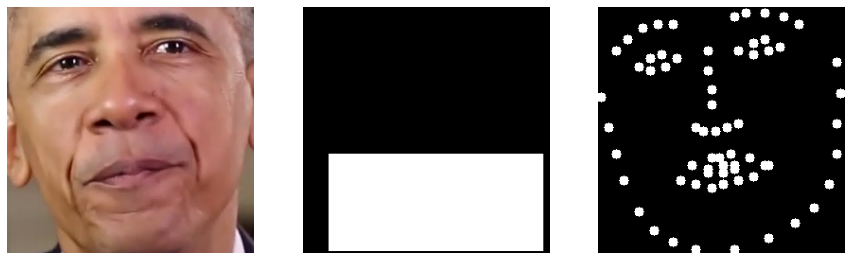

In [138]:
preds = fa.get_landmarks(face)  
x, y, w, h = cv2.boundingRect(np.array(preds[0][3:14]))
mask_img = cv2.rectangle(face.copy(), (x, y), (x + w, y + h), (255, 255, 255), -1)
raw_mask = cv2.rectangle(np.zeros(face.shape,face.dtype), (x, y), (x + w, y + h), (255, 255, 255), -1)

landmark_cord = preds[0]
landmark_img = np.zeros(face.shape,face.dtype)
for i in range(landmark_cord.shape[0]):
    center = (int(landmark_cord[i,0]),int(landmark_cord[i,1]))
    cv2.circle(landmark_img,center, radius=5,color=(255, 255, 255), thickness=-1)

SHOW([face,raw_mask,landmark_img])

In [140]:
import scipy
from PIL import Image
import torchvision
from skimage.color import rgb2gray

INPUT_SIZE= 256

def resize(img, mask,landmarks, height, width):
    size_before = img.shape
    img = scipy.misc.imresize(img, [height, width])
    img = Image.fromarray(img)
    img_t = torchvision.transforms.functional.to_tensor(img).float()
    
    mask = scipy.misc.imresize(mask, [height, width])
    mask = rgb2gray(mask)
    mask = (mask > 0).astype(np.uint8) * 255
    mask = Image.fromarray(mask)
    mask_t = torchvision.transforms.functional.to_tensor(mask).float()
    
    side = np.minimum(size_before[0],size_before[1])
    
    landmarks[:,0] *= (height/side)
    landmarks[:,1] *= (width/side)
    landmarks = (landmarks+0.5).astype(np.int16)
    landmarks = torch.from_numpy(landmarks).long()
    
    return img_t,mask_t,landmarks

images,masks,landmarks = resize(face,raw_mask,landmark_cord,INPUT_SIZE,INPUT_SIZE)

landmarks[landmarks >= INPUT_SIZE-1] = INPUT_SIZE-1
landmarks[landmarks < 0] = 0

landmark_map = torch.zeros(1, INPUT_SIZE,INPUT_SIZE)
landmark_map[0, landmarks[0:INPUT_SIZE, 1], landmarks[0:INPUT_SIZE, 0]] = 1
images = images.unsqueeze(dim=0)
masks = masks.unsqueeze(dim=0)
landmark_map = landmark_map.unsqueeze(dim=0).float()

images_masked = (images * (1 - masks).float()) + masks
inputs = torch.cat((images_masked, landmark_map), dim=1)
scaled_masks_quarter = torch.nn.functional.interpolate(masks, size=[int(masks.shape[2] / 4), int(masks.shape[3] / 4)],
                            mode='bilinear', align_corners=True)
scaled_masks_half = torch.nn.functional.interpolate(masks, size=[int(masks.shape[2] / 2), int(masks.shape[3] / 2)],
                            mode='bilinear', align_corners=True)
outputs = model(inputs,masks,scaled_masks_half,scaled_masks_quarter) 

/data/chengbin/anaconda3/envs/torch0.4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # Remove the CWD from sys.path while we load stuff.
/data/chengbin/anaconda3/envs/torch0.4/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


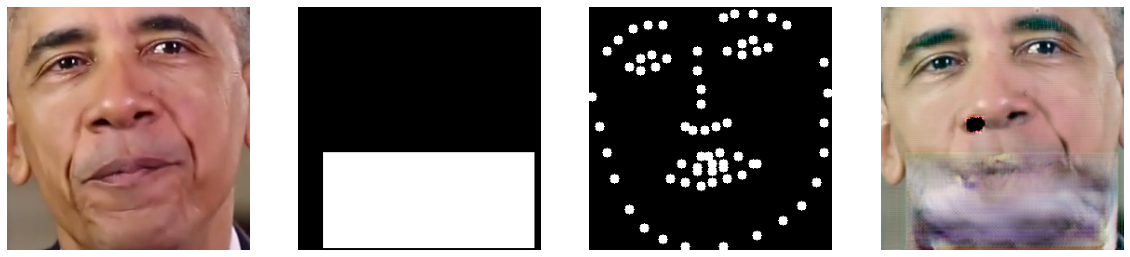

In [141]:
SHOW([face,raw_mask,landmark_img,np.transpose(outputs[0].data.cpu().numpy(),(1,2,0))])

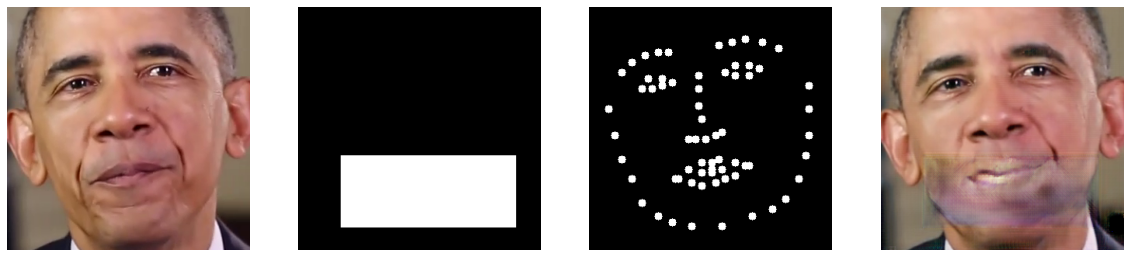

In [135]:
SHOW([face,raw_mask,landmark_img,np.transpose(outputs[0].data.cpu().numpy(),(1,2,0))])

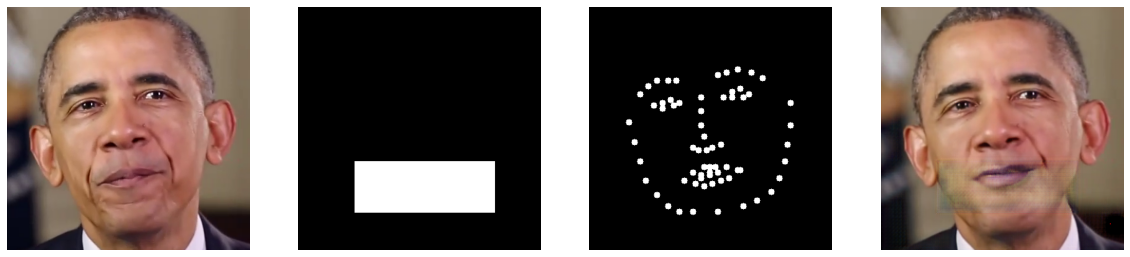

In [121]:
SHOW([face,raw_mask,landmark_img,np.transpose(outputs[0].data.cpu().numpy(),(1,2,0))])

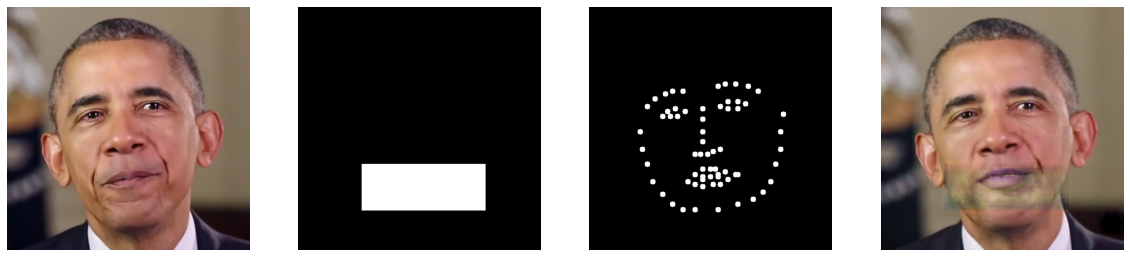

In [125]:
SHOW([face,raw_mask,landmark_img,np.transpose(outputs[0].data.cpu().numpy(),(1,2,0))])

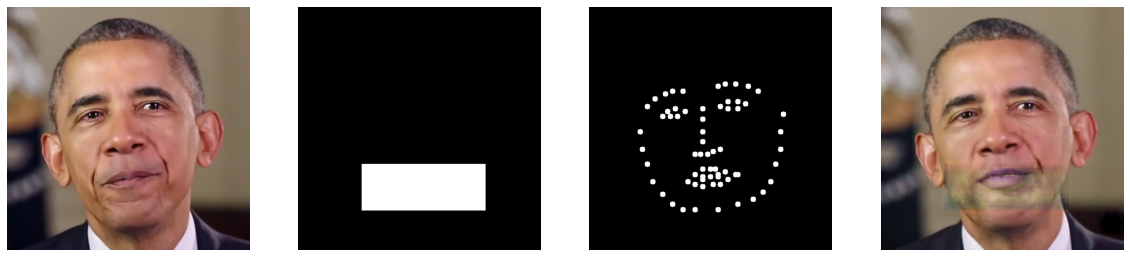

In [131]:
SHOW([face,raw_mask,landmark_img,np.transpose(outputs[0].data.cpu().numpy(),(1,2,0))])

In [1]:
import face_alignment
from skimage import io
import cv2
from cv2 import circle

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)

input_img = io.imread('aobama1.png')
print(input_img.shape)
input_img = cv2.resize(input_img, (256,256), interpolation = cv2.INTER_AREA)
input_img = input_img[:,:,[0,1,2]]
print(input_img.shape)
preds = fa.get_landmarks(input_img)

landmark_cord = preds[0].copy()
landmark_img = np.zeros(input_img.shape,input_img.dtype)
for i in range(landmark_cord.shape[0]):
    center = (int(landmark_cord[i,0]),int(landmark_cord[i,1]))
    #cv2.putText(landmark_img, str(i), center, cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), 2)
    circle(landmark_img,center, radius=5,color=(255, 255, 255), thickness=-1)
    
x, y, w, h = cv2.boundingRect(np.array(preds[0][3:14,:]))
mask_img = cv2.rectangle(input_img.copy(), (x, y), (x + w, y + h), (255, 255, 255), -1)
mask = cv2.rectangle(np.zeros(input_img.shape,input_img.dtype), (x, y), (x + w, y + h), (255, 255, 255), -1)
    
SHOW([input_img,landmark_img,mask_img,mask],figsize=(40,10))

FileNotFoundError: No such file: '/home/chengbin/code/lafin_school/aobama1.png'